# Neural Network Modeling V1

In [130]:
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from glob import glob
import pandas as pd
from torch.utils.data import Dataset, DataLoader,random_split


## Dataset Preparation

We define a custom PyTorch dataset that loads Duffing oscillator simulation data from CSV files,
slices it into fixed-length input windows, and generates the next point as the target for supervised learning.


In [131]:
class DuffingDataset(Dataset):
    def __init__(self, data_dir, window_size=10):
        """
        Args:
            data_dir (str): Directory containing CSV simulation files.
            window_size (int): Number of time steps to use as input for prediction.
        """
        self.window_size = window_size

        # Initialize scalers as attributes (used for normalization and inversion)
        self.scaler_X = StandardScaler()
        self.scaler_y = StandardScaler()

        # Load and process data
        self.X, self.y = self.create_dataset_from_csv(data_dir)

    def create_dataset_from_csv(self, data_dir):
        """
        Loads Duffing simulation data from a subset of CSV files and creates input-output pairs.
        """
        all_csv_files = sorted(glob(os.path.join(data_dir, "*.csv")))

        # ⚠️ Only load a random sample (e.g., 10 files)
        np.random.seed(42)
        selected_files = np.random.choice(all_csv_files, size=100, replace=False)

        X_all, y_all = [], []

        for file in selected_files:
            df = pd.read_csv(file)

            # Optional: downsample (every 5th point)
            df = df.iloc[::5].reset_index(drop=True)

            series = df[["x", "v"]].values
            for i in range(len(series) - self.window_size - 1):
                window = series[i:i+self.window_size].flatten()
                target = series[i+self.window_size]
                X_all.append(window)
                y_all.append(target)

        X_all = np.array(X_all)
        y_all = np.array(y_all)

        # Normalize features and targets
        X_scaled = self.scaler_X.fit_transform(X_all)
        y_scaled = self.scaler_y.fit_transform(y_all)

        return torch.tensor(X_scaled, dtype=torch.float32), torch.tensor(y_scaled, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [132]:
data_dir = "../data/raw/"
window_size = 10
full_dataset = DuffingDataset(data_dir, window_size)

total_size = len(full_dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)
)


In [133]:
from torch.utils.data import DataLoader

batch_size = 64

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [134]:
print(f"Train size: {len(train_dataset)}")
print(f"Validation size: {len(val_dataset)}")
print(f"Test size: {len(test_dataset)}")

Train size: 139230
Validation size: 29835
Test size: 29835


In [135]:
for name, ds in [("Train", train_dataset), ("Val", val_dataset), ("Test", test_dataset)]:
    x, y = ds[0]
    print(f"{name} sample:")
    print(f"  Input shape: {x.shape} → values: {x[:4]} ...")
    print(f"  Target shape: {y.shape} → values: {y}\n")

Train sample:
  Input shape: torch.Size([20]) → values: tensor([0.3893, 0.8403, 0.4378, 0.8301]) ...
  Target shape: torch.Size([2]) → values: tensor([0.8622, 0.8025])

Val sample:
  Input shape: torch.Size([20]) → values: tensor([-0.3383, -0.8602, -0.3888, -0.8787]) ...
  Target shape: torch.Size([2]) → values: tensor([-0.8905, -1.0174])

Test sample:
  Input shape: torch.Size([20]) → values: tensor([ 1.8461, -1.4282,  1.7575, -1.6278]) ...
  Target shape: torch.Size([2]) → values: tensor([ 0.7423, -1.9391])



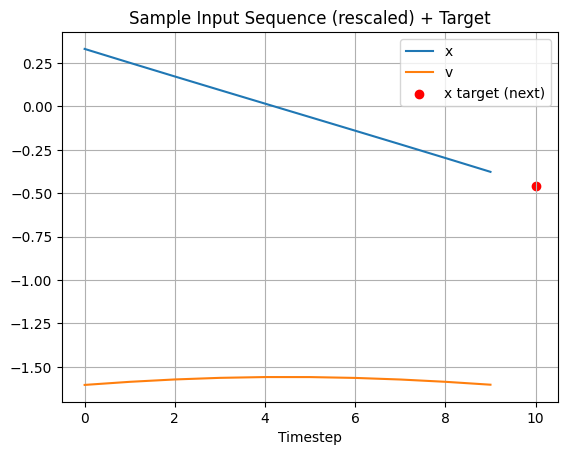

In [136]:
sample_x, sample_y = train_dataset[3330]
x_seq_rescaled = full_dataset.scaler_X.inverse_transform(sample_x.unsqueeze(0).numpy()).reshape(-1, 2)
y_rescaled = full_dataset.scaler_y.inverse_transform(sample_y.unsqueeze(0).numpy())[0]

plt.plot(x_seq_rescaled[:, 0], label="x")
plt.plot(x_seq_rescaled[:, 1], label="v")
plt.scatter(len(x_seq_rescaled), y_rescaled[0], color="red", label="x target (next)")
plt.title("Sample Input Sequence (rescaled) + Target")
plt.xlabel("Timestep")
plt.legend()
plt.grid(True)
plt.show()

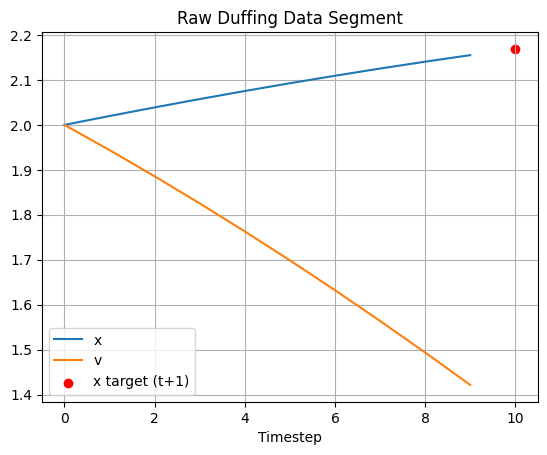

In [137]:
df = pd.read_csv("../data/raw/F0.7_d0.10_w1.2_sim_199.csv")  # update filename as needed
series = df[["x", "v"]].values
i = 0
window_size = 10

segment = series[i:i+window_size+1]
x_seq = segment[:-1, 0]
v_seq = segment[:-1, 1]
x_target = segment[-1, 0]

plt.plot(range(window_size), x_seq, label="x")
plt.plot(range(window_size), v_seq, label="v")
plt.scatter(window_size, x_target, color='red', label="x target (t+1)")
plt.title("Raw Duffing Data Segment")
plt.xlabel("Timestep")
plt.legend()
plt.grid(True)
plt.show()


## Neural Network Architecture

We use a simple feedforward neural network (MLP) to predict the next state of the system (x, v)
given a short history of previous values. The input is flattened as a 2 × window_size vector.

In [138]:
import torch
import torch.nn as nn

class DuffingFFNN(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=2):
        """
        input_dim: 2 × window_size
        hidden_dim: number of units in hidden layers
        output_dim: 2 (predict x and v at next step)
        """
        super(DuffingFFNN, self).__init__()

        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, output_dim)
        )

    def forward(self, x):
        return self.model(x)


## Training Procedure

We train using MSE loss and monitor validation error to prevent overfitting.
The network should learn to approximate the short-term dynamics of the Duffing oscillator.

In [139]:
def train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=50, device="cpu", log_interval=10):
    model.to(device)

    train_losses = []
    val_losses = []

    for epoch in range(n_epochs):
        # ----- Training -----
        model.train()
        total_train_loss = 0

        for x_batch, y_batch in train_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()

        avg_train_loss = total_train_loss / len(train_loader)
        train_losses.append(avg_train_loss)

        # ----- Validation -----
        model.eval()
        total_val_loss = 0

        with torch.no_grad():
            for x_val, y_val in val_loader:
                x_val, y_val = x_val.to(device), y_val.to(device)
                val_pred = model(x_val)
                val_loss = loss_fn(val_pred, y_val)
                total_val_loss += val_loss.item()

        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)

        # ----- Logging -----
        if (epoch + 1) % log_interval == 0 or epoch == 0 or epoch == n_epochs - 1:
            print(f"Epoch {epoch+1:02d} | Train Loss: {avg_train_loss:.6f} | Val Loss: {avg_val_loss:.6f}")

    return train_losses, val_losses


## Model Evaluation

We evaluate the model on the test set and visualize predictions for position and velocity.
This tells us how well the model captures the local flow of the system.

In [140]:
def evaluate_model(model, dataset, scaler_y, device="cpu", n_samples=200):
    model.eval()
    model.to(device)

    with torch.no_grad():
        X = dataset.X[:n_samples].to(device)
        y_true = dataset.y[:n_samples].to(device)

        y_pred = model(X).cpu().numpy()
        y_true = y_true.cpu().numpy()

        y_pred_rescaled = scaler_y.inverse_transform(y_pred)
        y_true_rescaled = scaler_y.inverse_transform(y_true)

    return y_pred_rescaled, y_true_rescaled


In [141]:
def plot_loss_curves(train_losses, val_losses):
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label="Train Loss")
    plt.plot(val_losses, label="Val Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


Epoch 01 | Train Loss: 0.004878 | Val Loss: 0.000148
Epoch 10 | Train Loss: 0.000048 | Val Loss: 0.000043
Epoch 20 | Train Loss: 0.000040 | Val Loss: 0.000029
Epoch 30 | Train Loss: 0.000031 | Val Loss: 0.000045
Epoch 40 | Train Loss: 0.000027 | Val Loss: 0.000012
Epoch 50 | Train Loss: 0.000019 | Val Loss: 0.000021


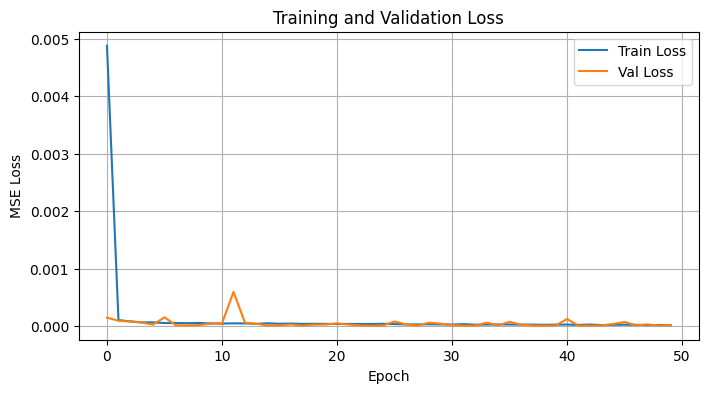

In [142]:
# Initialize model
window_size = 10
input_dim = 2 * window_size
lr = 1e-3

model = DuffingFFNN(input_dim=input_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
loss_fn = nn.MSELoss()

# Train and validate
train_losses, val_losses = train_model(model, optimizer, loss_fn, train_loader, val_loader, n_epochs=50)

# Plot loss curves
plot_loss_curves(train_losses, val_losses)

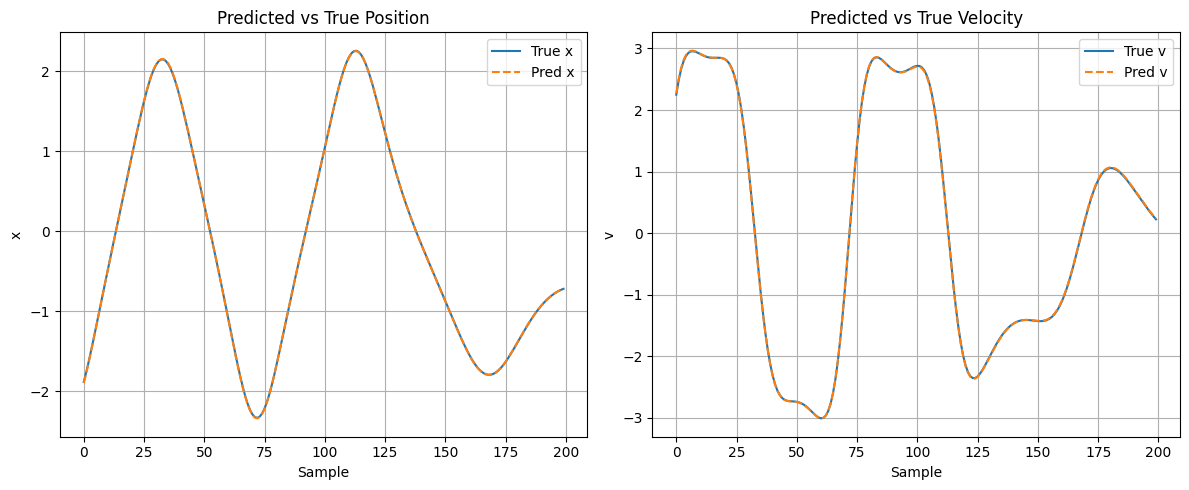

In [143]:
y_pred, y_true = evaluate_model(model, test_dataset.dataset, full_dataset.scaler_y, n_samples=200)

plt.figure(figsize=(12, 5))

# Position (x)
plt.subplot(1, 2, 1)
plt.plot(y_true[:, 0], label="True x")
plt.plot(y_pred[:, 0], label="Pred x", linestyle="--")
plt.title("Predicted vs True Position")
plt.xlabel("Sample")
plt.ylabel("x")
plt.legend()
plt.grid(True)

# Velocity (v)
plt.subplot(1, 2, 2)
plt.plot(y_true[:, 1], label="True v")
plt.plot(y_pred[:, 1], label="Pred v", linestyle="--")
plt.title("Predicted vs True Velocity")
plt.xlabel("Sample")
plt.ylabel("v")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## Recursive Simulation

Using the trained model, we simulate the future evolution of the system recursively.
This mimics real trajectory generation and tests the model's long-term generalization.

In [144]:
def recursive_simulation(model, initial_seq, full_dataset, n_steps=200, device="cpu"):
    model.eval()
    model.to(device)

    # Scale input using training scaler
    scaled_seq = full_dataset.scaler_X.transform(initial_seq.flatten().reshape(1, -1))
    current_input = torch.tensor(scaled_seq, dtype=torch.float32).to(device)

    pred_sequence = []

    for _ in range(n_steps):
        # Predict next [x, v]
        with torch.no_grad():
            pred = model(current_input).cpu().numpy()

        # Save unscaled prediction
        pred_rescaled = full_dataset.scaler_y.inverse_transform(pred)[0]
        pred_sequence.append(pred_rescaled)

        # Create new input window
        new_input = np.vstack((initial_seq[1:], pred_rescaled))  # shift + append
        scaled_input = full_dataset.scaler_X.transform(new_input.flatten().reshape(1, -1))
        current_input = torch.tensor(scaled_input, dtype=torch.float32).to(device)
        initial_seq = new_input

    return np.array(pred_sequence)


In [145]:
# Pick a file and extract real input
df = pd.read_csv("../data/raw/F0.7_d0.10_w1.2_sim_199.csv")  # or any CSV
df = df.iloc[::5].reset_index(drop=True)
series = df[["x", "v"]].values

# Use first 10 steps as seed input
initial_window = series[0:10]

# Run recursive prediction
recursive_pred = recursive_simulation(model, initial_window, full_dataset, n_steps=200)


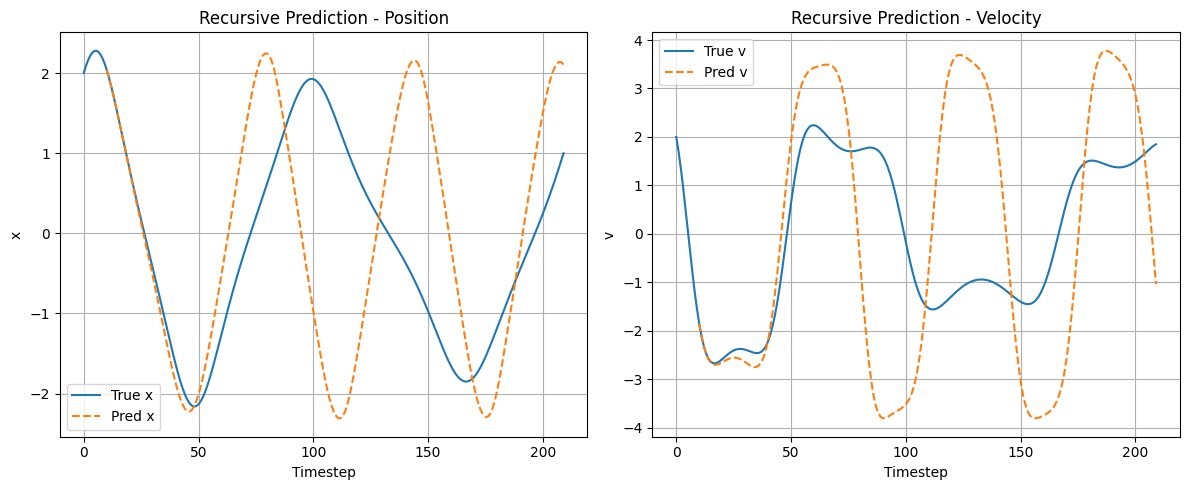

In [146]:
plt.figure(figsize=(12, 5))

# Position
plt.subplot(1, 2, 1)
plt.plot(series[0:210, 0], label="True x")
plt.plot(range(10, 210), recursive_pred[:, 0], label="Pred x", linestyle="--")
plt.title("Recursive Prediction - Position")
plt.xlabel("Timestep")
plt.ylabel("x")
plt.legend()
plt.grid(True)

# Velocity
plt.subplot(1, 2, 2)
plt.plot(series[0:210, 1], label="True v")
plt.plot(range(10, 210), recursive_pred[:, 1], label="Pred v", linestyle="--")
plt.title("Recursive Prediction - Velocity")
plt.xlabel("Timestep")
plt.ylabel("v")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## One-Step Prediction Error

We plot the L2 norm between the predicted and true values across the test set to see the distribution of prediction errors.

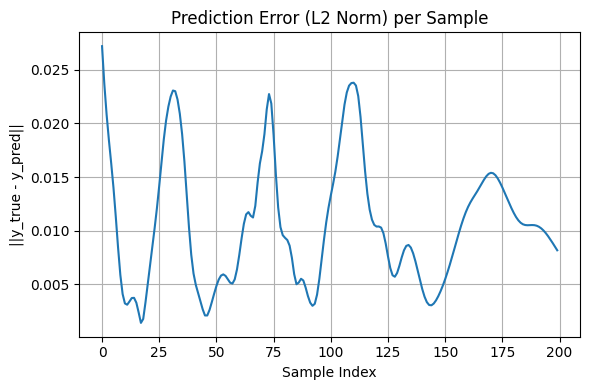

In [147]:
errors = np.linalg.norm(y_true - y_pred, axis=1)

plt.figure(figsize=(6, 4))
plt.plot(errors)
plt.title("Prediction Error (L2 Norm) per Sample")
plt.xlabel("Sample Index")
plt.ylabel("||y_true - y_pred||")
plt.grid(True)
plt.tight_layout()
plt.show()

## Recursive Prediction Error

Here we observe how error accumulates as the model recursively predicts future states.
This reflects the sensitivity to initial conditions and chaotic divergence in the Duffing system.

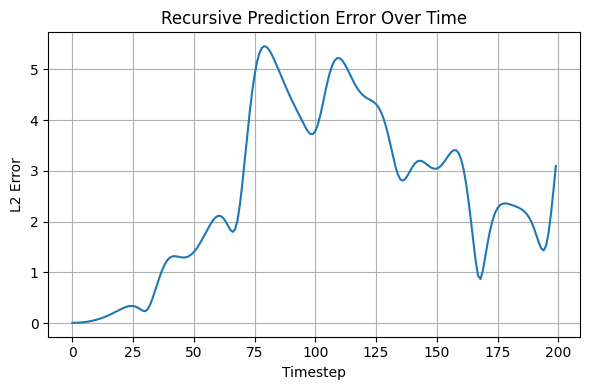

In [148]:
recursive_true = series[10:210]  # 200 true future steps
error_recursive = np.linalg.norm(recursive_true - recursive_pred, axis=1)

plt.figure(figsize=(6, 4))
plt.plot(error_recursive)
plt.title("Recursive Prediction Error Over Time")
plt.xlabel("Timestep")
plt.ylabel("L2 Error")
plt.grid(True)
plt.tight_layout()
plt.show()

## Summary

This notebook implemented one-step and recursive prediction of the Duffing oscillator using a neural network.
We evaluated the model both in short-term accuracy and long-term divergence.

In future work, we could explore:
- Training on more chaotic regimes
- Switching to recurrent models (LSTM, GRU)
- Augmenting the model with physics-informed priors or constraints